In [635]:
import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import StaleElementReferenceException
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [882]:
from textblob import TextBlob
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer 
from nltk import word_tokenize
import scipy.stats as stats
from scipy.stats import pearsonr

In [636]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## First Data set loaded in from file

In [638]:
la_crime = pd.read_csv('Arrest_Data_from_2020_to_Present.csv', encoding = 'utf-8')

In [639]:
display(la_crime.head(5))

,Report ID,Report Type,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,...,Disposition Description,Address,Cross Street,LAT,LON,Location,Booking Date,Booking Time,Booking Location,Booking Location Code
0,231413977,RFC,07/13/2023 12:00:00 AM,2330.0,14,Pacific,1412,29,M,H,...,MISDEMEANOR COMPLAINT FILED,BROOKS AV,OCEAN FRONT WK,33.9908,-118.4765,POINT (-118.4765 33.9908),NaN,NaN,NaN,NaN
1,231715213,RFC,09/01/2023 12:00:00 AM,2300.0,17,Devonshire,1738,17,F,H,...,COUNSELED/RELEASED,15800 TULSA ST,NaN,34.2682,-118.4760,POINT (-118.476 34.2682),NaN,NaN,NaN,NaN
2,230612568,RFC,07/14/2023 12:00:00 AM,2150.0,6,Hollywood,677,30,M,O,...,MISDEMEANOR COMPLAINT FILED,WESTERN,MARATHON,34.0845,-118.3091,POINT (-118.3091 34.0845),NaN,NaN,NaN,NaN
3,230119897,RFC,09/13/2023 12:00:00 AM,1332.0,1,Central,148,50,M,A,...,MISDEMEANOR COMPLAINT FILED,5TH,GLADYS,34.0421,-118.2405,POINT (-118.2405 34.0421),NaN,NaN,NaN,NaN
4,230214008,RFC,07/04/2023 12:00:00 AM,1445.0,2,Rampart,266,38,M,H,...,MISDEMEANOR COMPLAINT FILED,BONNIE BRAE,8TH,34.0539,-118.2756,POINT (-118.2756 34.0539),NaN,NaN,NaN,NaN


In [640]:
display(la_crime['Area Name'].unique())

array(['Pacific', 'Devonshire', 'Hollywood', 'Central', 'Rampart',
       'N Hollywood', 'West LA', 'Mission', 'Van Nuys', 'Southeast',
       'Wilshire', 'Topanga', 'Southwest', '77th Street', 'Hollenbeck',
       'Northeast', 'Olympic', 'West Valley', 'Newton', 'Foothill',
       'Harbor'], dtype=object)

In [641]:
la_crime = la_crime.drop(['Report Type', 'Descent Code', 'Cross Street', 'Booking Location Code', 'Booking Time', 'Disposition Description', 'Time', 'Reporting District', 'Charge Group Code', 'Arrest Type Code', 'Charge', 'LAT', 'LON', 'Booking Date', 'Booking Location', 'Location'], axis = 1)

In [642]:
display(la_crime.head(5))

,Report ID,Arrest Date,Area ID,Area Name,Age,Sex Code,Charge Group Description,Charge Description,Address
0,231413977,07/13/2023 12:00:00 AM,14,Pacific,29,M,NaN,NaN,BROOKS AV
1,231715213,09/01/2023 12:00:00 AM,17,Devonshire,17,F,NaN,NaN,15800 TULSA ST
2,230612568,07/14/2023 12:00:00 AM,6,Hollywood,30,M,Prostitution/Allied,PROSTITUTION,WESTERN
3,230119897,09/13/2023 12:00:00 AM,1,Central,50,M,NaN,NaN,5TH
4,230214008,07/04/2023 12:00:00 AM,2,Rampart,38,M,NaN,NaN,BONNIE BRAE


In [643]:
la_crime.dtypes

Report ID                    int64
Arrest Date                 object
Area ID                      int64
Area Name                   object
Age                          int64
Sex Code                    object
Charge Group Description    object
Charge Description          object
Address                     object
dtype: object

In [644]:
la_crime['Arrest Date'] = la_crime['Arrest Date'].str.replace('12:00:00 AM', '',regex= False)

In [645]:
la_crime['Arrest Date'] = la_crime['Arrest Date'].str.strip()

In [646]:
display(la_crime['Arrest Date'])

0         07/13/2023
1         09/01/2023
2         07/14/2023
3         09/13/2023
4         07/04/2023
             ...    
342321    11/20/2024
342322    11/17/2024
342323    11/16/2024
342324    11/19/2024
342325    11/19/2024
Name: Arrest Date, Length: 342326, dtype: object

In [647]:
la_crime['Arrest Date'] = pd.to_datetime(la_crime['Arrest Date'],format='%m/%d/%Y')

In [648]:
la_crime['Area Name'] = la_crime['Area Name'].astype(str)

In [649]:
la_crime['Charge Group Description'] = la_crime['Charge Group Description'].astype(str)

In [650]:
la_crime['Charge Description'] = la_crime['Charge Description'].astype(str)

In [651]:
la_crime.dtypes

Report ID                            int64
Arrest Date                 datetime64[ns]
Area ID                              int64
Area Name                           object
Age                                  int64
Sex Code                            object
Charge Group Description            object
Charge Description                  object
Address                             object
dtype: object

In [652]:
la_na = la_crime.isna().sum()
print(la_na)

Report ID                   0
Arrest Date                 0
Area ID                     0
Area Name                   0
Age                         0
Sex Code                    0
Charge Group Description    0
Charge Description          0
Address                     0
dtype: int64


In [653]:
display(la_crime.head(5))

,Report ID,Arrest Date,Area ID,Area Name,Age,Sex Code,Charge Group Description,Charge Description,Address
0,231413977,2023-07-13,14,Pacific,29,M,nan,nan,BROOKS AV
1,231715213,2023-09-01,17,Devonshire,17,F,nan,nan,15800 TULSA ST
2,230612568,2023-07-14,6,Hollywood,30,M,Prostitution/Allied,PROSTITUTION,WESTERN
3,230119897,2023-09-13,1,Central,50,M,nan,nan,5TH
4,230214008,2023-07-04,2,Rampart,38,M,nan,nan,BONNIE BRAE


In [654]:
la_crime.rename(columns={'Area Name': 'Community'}, inplace=True)

In [655]:
display(la_crime.head(5))

,Report ID,Arrest Date,Area ID,Community,Age,Sex Code,Charge Group Description,Charge Description,Address
0,231413977,2023-07-13,14,Pacific,29,M,nan,nan,BROOKS AV
1,231715213,2023-09-01,17,Devonshire,17,F,nan,nan,15800 TULSA ST
2,230612568,2023-07-14,6,Hollywood,30,M,Prostitution/Allied,PROSTITUTION,WESTERN
3,230119897,2023-09-13,1,Central,50,M,nan,nan,5TH
4,230214008,2023-07-04,2,Rampart,38,M,nan,nan,BONNIE BRAE


In [656]:
la_crime['Arrest Date'] = la_crime['Arrest Date'].dt.year

In [657]:
display(la_crime['Arrest Date'])

0         2023
1         2023
2         2023
3         2023
4         2023
          ... 
342321    2024
342322    2024
342323    2024
342324    2024
342325    2024
Name: Arrest Date, Length: 342326, dtype: int32

In [658]:
la_crime2023 = la_crime[la_crime['Arrest Date'] == 2023]

In [659]:
display(la_crime2023.head(5))

,Report ID,Arrest Date,Area ID,Community,Age,Sex Code,Charge Group Description,Charge Description,Address
0,231413977,2023,14,Pacific,29,M,nan,nan,BROOKS AV
1,231715213,2023,17,Devonshire,17,F,nan,nan,15800 TULSA ST
2,230612568,2023,6,Hollywood,30,M,Prostitution/Allied,PROSTITUTION,WESTERN
3,230119897,2023,1,Central,50,M,nan,nan,5TH
4,230214008,2023,2,Rampart,38,M,nan,nan,BONNIE BRAE


In [660]:
la_crime2023['Community'] = la_crime2023['Community'].str.replace(' hills', '', regex = False)

C:\Users\rtaba\AppData\Local\Temp\ipykernel_42560\2307409167.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  la_crime2023['Community'] = la_crime2023['Community'].str.replace(' hills', '', regex = False)


In [661]:
la_crime.to_csv('LA_Crime_Statistics.csv', encoding = 'utf-8')

## Second Data set scraped

In [886]:
# Takes 4-5 minutes to fully extract/load the data

In [663]:
options = webdriver.ChromeOptions() 
options.add_argument('--start-maximized')
browser = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options = options)

url = 'https://data.lacounty.gov/datasets/lacounty::unemployment-census-tract/explore?location=33.733638%2C-118.298767%2C6.48&showTable=true'
browser.get(url)
time.sleep(5)

WebDriverWait(browser, 20).until(
    EC.presence_of_element_located((By.CSS_SELECTOR, ".infinite-scroll-container table"))
)

scroll_container = WebDriverWait(browser, 20).until(
    EC.presence_of_element_located((By.CLASS_NAME, "infinite-scroll-container"))
)
scroll_pause = 1.5
prev_count = -1
same_count_attempts = 0
max_attempts = 5  # Stop after 20 idle scrolls

while same_count_attempts < max_attempts:
    browser.execute_script("arguments[0].scrollTop = arguments[0].scrollHeight", scroll_container)
    time.sleep(scroll_pause)

    rows = scroll_container.find_elements(By.CSS_SELECTOR, "tbody tr")
    current_count = len(rows)
    print(f"Rows loaded: {current_count}")

    if current_count == prev_count:
        same_count_attempts += 1
    else:
        same_count_attemps = 0
        prev_count = current_count

print(" Finished scrolling. Extracting data...")

# Now grab data from the fully loaded table
table = scroll_container.find_element(By.TAG_NAME, "table")
headers = table.find_elements(By.TAG_NAME, "th")
column_headers = [header.text.strip() for header in headers]

data_rows = []
for row in table.find_elements(By.CSS_SELECTOR, "tbody tr"):
    cells = row.find_elements(By.TAG_NAME, "td")
    if cells:
        data_rows.append([cell.text.strip() for cell in cells])

# Build DataFrame
unemployment_df = pd.DataFrame(data_rows, columns=column_headers)
print(unemployment_df.head())
print("Shape of full dataframe:", unemployment_df.shape)

#  Short delay to ensure output finishes before cleanup
time.sleep(1)
# Clean up
browser.quit()

Rows loaded: 50
Rows loaded: 75
Rows loaded: 100
Rows loaded: 125
Rows loaded: 150
Rows loaded: 175
Rows loaded: 200
Rows loaded: 225
Rows loaded: 250
Rows loaded: 275
Rows loaded: 300
Rows loaded: 325
Rows loaded: 350
Rows loaded: 375
Rows loaded: 400
Rows loaded: 425
Rows loaded: 450
Rows loaded: 475
Rows loaded: 500
Rows loaded: 525
Rows loaded: 550
Rows loaded: 575
Rows loaded: 600
Rows loaded: 625
Rows loaded: 650
Rows loaded: 675
Rows loaded: 700
Rows loaded: 725
Rows loaded: 750
Rows loaded: 775
Rows loaded: 800
Rows loaded: 825
Rows loaded: 850
Rows loaded: 875
Rows loaded: 900
Rows loaded: 925
Rows loaded: 950
Rows loaded: 975
Rows loaded: 1000
Rows loaded: 1025
Rows loaded: 1050
Rows loaded: 1075
Rows loaded: 1100
Rows loaded: 1125
Rows loaded: 1150
Rows loaded: 1175
Rows loaded: 1200
Rows loaded: 1225
Rows loaded: 1250
Rows loaded: 1275
Rows loaded: 1300
Rows loaded: 1325
Rows loaded: 1350
Rows loaded: 1375
Rows loaded: 1400
Rows loaded: 1425
Rows loaded: 1450
Rows loaded: 1

In [664]:
display(unemployment_df)

,Census Tract,Name,Percent Unemployed,Supervisor District,City or Community,SPA,Shape__Area,Shape__Length
0,06037101110,1011.10,4.5,District 5,Los Angeles - Tujunga,SPA 2 - San Fernando,"12,329,806.215","14,765.649"
1,06037101122,1011.22,6.1,District 5,Los Angeles - Tujunga,SPA 2 - San Fernando,"29,088,657.192","30,028.214"
2,06037101220,1012.20,5.6,District 5,Los Angeles - Tujunga,SPA 2 - San Fernando,"7,532,651.155","12,504.552"
3,06037101221,1012.21,1.9,District 5,Los Angeles - Tujunga,SPA 2 - San Fernando,"3,874,399.418","8,938.421"
4,06037101222,1012.22,3.8,District 5,Los Angeles - Tujunga,SPA 2 - San Fernando,"3,090,537.728","9,750.96"
...,...,...,...,...,...,...,...,...
2490,06037980035,9800.35,4.3,District 1,City of Industry,SPA 3 - San Gabriel,"171,530,631.979","105,850.879"
2491,06037980036,9800.36,0,District 1,Unincorporated - Whittier Narrows,SPA 3 - San Gabriel,"94,108,944.027","63,183.083"
2492,06037980037,9800.37,,District 2,City of Carson,SPA 8 - South Bay,"13,764,458.922","14,866.138"
2493,06037980038,9800.38,,District 2,Unincorporated - Ladera Heights,SPA 5 - West,"48,526,563.491","42,566.84"


In [665]:
display(la_crime2023['Community'].unique())

array(['Pacific', 'Devonshire', 'Hollywood', 'Central', 'Rampart',
       'N Hollywood', 'West LA', 'Mission', 'Van Nuys', 'Southeast',
       'Wilshire', 'Topanga', 'Southwest', '77th Street', 'Hollenbeck',
       'Northeast', 'Olympic', 'West Valley', 'Newton', 'Foothill',
       'Harbor'], dtype=object)

In [666]:
display(unemployment_df['City or Community'].unique())

array(['Los Angeles - Tujunga', 'Los Angeles - Sun Valley',
       'Los Angeles - Sunland', 'Los Angeles - Lakeview Terrace',
       'Los Angeles - Shadow Hills', 'Los Angeles - Pacoima',
       'Unincorporated - Kagel/Lopez Canyons', 'Los Angeles - Sylmar',
       'Los Angeles - Granada Hills', 'Los Angeles - Porter Ranch',
       'Los Angeles - Mission Hills', 'Los Angeles - North Hills',
       'Los Angeles - Northridge', 'Los Angeles - Chatsworth',
       'Unincorporated - West Chatsworth', 'Los Angeles - West Hills',
       'Los Angeles - Canoga Park', 'Unincorporated - Lake Manor',
       'Los Angeles - Winnetka', 'Los Angeles - Arleta',
       'Los Angeles - Panorama City', 'Los Angeles - North Hollywood',
       'Los Angeles - Valley Glen', 'Los Angeles - Van Nuys',
       'Los Angeles - Valley Village', 'Los Angeles - Sherman Oaks',
       'Los Angeles - Toluca Lake', 'Los Angeles - Toluca Woods',
       'Los Angeles - Lake Balboa', 'Los Angeles - Reseda',
       'Los Angeles 

In [667]:
unemployment_df = unemployment_df.drop(['Name', 'Shape__Area', 'Shape__Length'], axis = 1)

In [668]:
unemployment_df = unemployment_df.drop(['SPA'], axis = 1)

In [669]:
unemployment_df['Census Tract'] = unemployment_df['Census Tract'].astype('int64')

In [670]:
un_na = unemployment_df.isna().sum()

In [671]:
unemployment_df.rename(columns={'City or Community': 'Area Name'}, inplace=True)

In [672]:
unemployment_df['Area Name'] = unemployment_df['Area Name'].str.replace('Los Angeles -', '', regex=False).str.strip()

In [673]:
unemployment_df['Percent Unemployed'] = pd.to_numeric(unemployment_df['Percent Unemployed'])

In [674]:
unemployment_df.index = unemployment_df.index.astype(str)

In [675]:
unemployment_df.dtypes

Census Tract             int64
Percent Unemployed     float64
Supervisor District     object
Area Name               object
dtype: object

In [676]:
unemployment_df['Area Name'] = unemployment_df['Area Name'].replace('City of ', '', regex= False)
unemployment_df['Area Name'] = unemployment_df['Area Name'].replace('North', 'N', regex= False)
unemployment_df['Area Name'] = unemployment_df['Area Name'].replace('West', 'W', regex= False)
unemployment_df.rename(columns={'Area Name': 'Community'}, inplace=True)

In [677]:
unemployment_df.drop_duplicates(inplace = True)

In [678]:
def clean_community(col):
    return col.str.strip().str.lower()

la_crime['Community'] = clean_community(la_crime['Community'])
unemployment_df['Community'] = clean_community(unemployment_df['Community'])

In [679]:
unemployed_grouped = (
    unemployment_df
    .groupby('Community', as_index=False)
    .agg({'Percent Unemployed': 'mean', 'Supervisor District': 'first'})
)

In [680]:
unemployed_grouped['Community'] = unemployed_grouped['Community'].str.replace('city of ', '', regex = False)
unemployed_grouped['Community'] = unemployed_grouped['Community'].str.replace(' palisades', '', regex = False)
unemployed_grouped['Community'] = unemployed_grouped['Community'].str.replace('unincorporated - ', '', regex = False)
unemployed_grouped['Community'] = unemployed_grouped['Community'].str.replace(' hills', '', regex = False)
unemployed_grouped['Community'] = unemployed_grouped['Community'].str.replace('north', 'n', regex = False)
unemployed_grouped['Community'] = unemployed_grouped['Community'].str.replace(' gateway', '', regex = False)
display(unemployed_grouped['Community'].unique())

array(['adams-normandie', 'alsace', 'angeles national forest',
       'angelino heights', 'arleta', 'atwater village', 'baldwin',
       'bel air', 'beverly crest', 'beverlywood', 'boyle heights',
       'brentwood', 'cadillac-corning', 'canoga park', 'carthay',
       'central', 'century city', 'century palms/cove', 'chatsworth',
       'cheviot', 'chinatown', 'agoura', 'alhambra', 'arcadia', 'artesia',
       'avalon', 'azusa', 'baldwin park', 'bell', 'bell gardens',
       'bellflower', 'beverly', 'bradbury', 'burbank', 'calabasas',
       'carson', 'cerritos', 'claremont', 'commerce', 'compton', 'covina',
       'cudahy', 'culver city', 'diamond bar', 'downey', 'duarte',
       'el monte', 'el segundo', 'gardena', 'glendale', 'glendora',
       'hawaiian gardens', 'hawthorne', 'hermosa beach',
       'huntington park', 'industry', 'inglewood', 'irwindale',
       'la canada flintridge', 'la habra heights', 'la mirada',
       'la puente', 'la verne', 'lakewood', 'lancaster', 'lawnd

In [681]:
la_crime2023.loc[: ,'Community'] = la_crime2023['Community'].str.lower()

In [682]:
display(la_crime2023['Community'].unique())

array(['pacific', 'devonshire', 'hollywood', 'central', 'rampart',
       'n hollywood', 'west la', 'mission', 'van nuys', 'southeast',
       'wilshire', 'topanga', 'southwest', '77th street', 'hollenbeck',
       'northeast', 'olympic', 'west valley', 'newton', 'foothill',
       'harbor'], dtype=object)

In [683]:
display(unemployed_grouped['Community'].unique())

array(['adams-normandie', 'alsace', 'angeles national forest',
       'angelino heights', 'arleta', 'atwater village', 'baldwin',
       'bel air', 'beverly crest', 'beverlywood', 'boyle heights',
       'brentwood', 'cadillac-corning', 'canoga park', 'carthay',
       'central', 'century city', 'century palms/cove', 'chatsworth',
       'cheviot', 'chinatown', 'agoura', 'alhambra', 'arcadia', 'artesia',
       'avalon', 'azusa', 'baldwin park', 'bell', 'bell gardens',
       'bellflower', 'beverly', 'bradbury', 'burbank', 'calabasas',
       'carson', 'cerritos', 'claremont', 'commerce', 'compton', 'covina',
       'cudahy', 'culver city', 'diamond bar', 'downey', 'duarte',
       'el monte', 'el segundo', 'gardena', 'glendale', 'glendora',
       'hawaiian gardens', 'hawthorne', 'hermosa beach',
       'huntington park', 'industry', 'inglewood', 'irwindale',
       'la canada flintridge', 'la habra heights', 'la mirada',
       'la puente', 'la verne', 'lakewood', 'lancaster', 'lawnd

In [684]:
la_crime2023.loc[: ,'Community'] = la_crime2023['Community'].replace('southeast', 'norwalk')

## Join Both Tables

In [686]:
la_unemployed = pd.merge(la_crime2023, unemployed_grouped, on='Community', how='inner')
display(la_unemployed)

,Report ID,Arrest Date,Area ID,Community,Age,Sex Code,Charge Group Description,Charge Description,Address,Percent Unemployed,Supervisor District
0,231413977,2023,14,pacific,29,M,nan,nan,BROOKS AV,2.440000,District 3
1,230612568,2023,6,hollywood,30,M,Prostitution/Allied,PROSTITUTION,WESTERN,6.913043,District 3
2,230612568,2023,6,hollywood,30,M,Prostitution/Allied,PROSTITUTION,WESTERN,6.390000,District 5
3,230119897,2023,1,central,50,M,nan,nan,5TH,6.322222,District 2
4,231514794,2023,15,n hollywood,30,M,nan,nan,5300 LANKERSHIM BL,6.035897,District 3
...,...,...,...,...,...,...,...,...,...,...,...
32691,6680121,2023,15,n hollywood,33,M,Weapon (carry/poss),POSS F/ARM BY CONVICTED FELON/ADDICT/ETC,VINELAND,6.035897,District 3
32692,6690508,2023,15,n hollywood,26,M,Miscellaneous Other Violations,VANDALISM W/LOSS VALUED EQ OR > $400,11600 VICTORY BL,6.035897,District 3
32693,6652667,2023,18,norwalk,47,M,Aggravated Assault,CORPORAL INJURY ON SPOUSE/COHABITANT/ETC,700 E 110TH ST,3.438095,District 4
32694,6691013,2023,15,n hollywood,16,M,Miscellaneous Other Violations,VANDALISM W/LOSS VALUED EQ OR > $400,TUJUNGA AV,6.035897,District 3


In [687]:
la_unemployed = la_unemployed.replace('nan', pd.NA)

In [688]:
la_cleaned = la_unemployed.dropna()

In [689]:
display(la_cleaned)

,Report ID,Arrest Date,Area ID,Community,Age,Sex Code,Charge Group Description,Charge Description,Address,Percent Unemployed,Supervisor District
1,230612568,2023,6,hollywood,30,M,Prostitution/Allied,PROSTITUTION,WESTERN,6.913043,District 3
2,230612568,2023,6,hollywood,30,M,Prostitution/Allied,PROSTITUTION,WESTERN,6.390000,District 5
6,230801062,2023,8,west la,40,M,Vehicle Theft,TAKE VEHICLE W/O OWNER'S CONSENT,PICO,1.600000,District 3
12,6641569,2023,15,n hollywood,42,M,Weapon (carry/poss),POSS F/ARM BY CONVICTED FELON/ADDICT/ETC,6700 TROOST AV,6.035897,District 3
13,6636901,2023,1,central,42,M,Robbery,CARJACKING,18TH,6.322222,District 2
...,...,...,...,...,...,...,...,...,...,...,...
32691,6680121,2023,15,n hollywood,33,M,Weapon (carry/poss),POSS F/ARM BY CONVICTED FELON/ADDICT/ETC,VINELAND,6.035897,District 3
32692,6690508,2023,15,n hollywood,26,M,Miscellaneous Other Violations,VANDALISM W/LOSS VALUED EQ OR > $400,11600 VICTORY BL,6.035897,District 3
32693,6652667,2023,18,norwalk,47,M,Aggravated Assault,CORPORAL INJURY ON SPOUSE/COHABITANT/ETC,700 E 110TH ST,3.438095,District 4
32694,6691013,2023,15,n hollywood,16,M,Miscellaneous Other Violations,VANDALISM W/LOSS VALUED EQ OR > $400,TUJUNGA AV,6.035897,District 3


# Descriptive Analytics Portion

### Logistic Regression

In [890]:
# binary logisitic regression: how good is our model at predicting violent crimes

In [692]:
violent_crimes = [
    'Aggravated Assault',
    'Weapon (carry/poss)',
    'Corporal Injury On Spouse/Cohabitant/Etc',
    'Robbery',
    'Homicide'
]

In [693]:
la_unemployed['is_violent'] = la_unemployed['Charge Group Description'].isin(violent_crimes).astype(int)
display(la_unemployed[['Charge Group Description', 'is_violent']])

,Charge Group Description,is_violent
0,<NA>,0
1,Prostitution/Allied,0
2,Prostitution/Allied,0
3,<NA>,0
4,<NA>,0
...,...,...
32691,Weapon (carry/poss),1
32692,Miscellaneous Other Violations,0
32693,Aggravated Assault,1
32694,Miscellaneous Other Violations,0


In [694]:
X = la_unemployed[['Age', 'Sex Code', 'Percent Unemployed', 'Community']]
y = la_unemployed['is_violent']

In [695]:
X = X.dropna()
y = y[X.index]

In [696]:
X = pd.get_dummies(X, columns=['Sex Code', 'Community'], drop_first=True)
X = X.astype(int)

In [697]:
display(X.head())
display(y.head())

,Age,Percent Unemployed,Sex Code_M,Community_harbor,Community_hollywood,Community_mission,Community_n hollywood,Community_norwalk,Community_pacific,Community_van nuys,Community_west la
0,29,2,1,0,0,0,0,0,1,0,0
1,30,6,1,0,1,0,0,0,0,0,0
2,30,6,1,0,1,0,0,0,0,0,0
3,50,6,1,0,0,0,0,0,0,0,0
4,30,6,1,0,0,0,1,0,0,0,0


0    0
1    0
2    0
3    0
4    0
Name: is_violent, dtype: int32

In [698]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

# Create and fit the model
violent_log = LogisticRegression(max_iter=1000)
violent_log.fit(X_train, y_train)

# Predict on test set
log_pred = violent_log.predict(X_test)

# Display predictions
print(log_pred)

[0 0 0 ... 0 0 0]


In [699]:
# Compute F1 Score
f1_log = f1_score(y_test, log_pred, average='weighted')

print("F1 Score - Logistic Regression:", f1_log)

F1 Score - Logistic Regression: 0.691023380509223


### This model is moderately good at predicting violent crimes, correctly balancing precision and recall about 69% of the time

## Willie ---> Descriptive Analytics (Mainly the stats that will be shown on PowerPoint, as well as Text Sentiment Analysis (Extreme of Crime)? 

In [765]:
display(la_cleaned['Percent Unemployed'].unique())

array([6.91304348, 6.39      , 1.6       , 6.03589744, 6.32222222,
       7.47727273, 2.44      , 3.43809524, 3.95      , 5.23333333])

In [767]:
percent_unemployed = la_cleaned.groupby('Community')['Percent Unemployed'].mean().reset_index()

In [769]:
display(percent_unemployed)

,Community,Percent Unemployed
0,central,6.322222
1,harbor,5.233333
2,hollywood,6.651522
3,mission,3.950000
4,n hollywood,6.035897
5,norwalk,3.438095
6,pacific,2.440000
7,van nuys,7.477273
8,west la,1.600000


In [ ]:
# Sentient analysis of different levels of unemployment (Low, Medium, High)

In [773]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [774]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [775]:
pip install vaderSentiment

   ---------------------------------------- 0.0/126.0 kB ? eta -:--:--
   ---------------------------------------  122.9/126.0 kB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 126.0/126.0 kB 1.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [785]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#### Low ---> West La (1.6% Unemployed)

In [788]:
west_la = la_cleaned[la_cleaned['Community'] == 'west la']

In [790]:
sentience = SentimentIntensityAnalyzer()

In [794]:
west_la.loc[:, 'Sentiment'] = west_la['Charge Group Description'].apply(lambda x: sentience.polarity_scores(x)['compound'])
display(west_la)

,Report ID,Arrest Date,Area ID,Community,Age,Sex Code,Charge Group Description,Charge Description,Address,Percent Unemployed,Supervisor District,Sentiment
6,230801062,2023,8,west la,40,M,Vehicle Theft,TAKE VEHICLE W/O OWNER'S CONSENT,PICO,1.6,District 3,0.0000
24,6639649,2023,8,west la,40,M,Miscellaneous Other Violations,VANDALISM,PACIFIC COAST HY,1.6,District 3,-0.5267
26,230811778,2023,8,west la,29,M,Other Assaults,BATTERY,SANTA MONICA BL,1.6,District 3,-0.5423
31,6708327,2023,8,west la,47,F,Burglary,BURGLARY,1100 S HOLT AV,1.6,District 3,0.0000
52,230812033,2023,8,west la,18,F,Larceny,SHOPLIFTING,10200 SANTA MONICA BL,1.6,District 3,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
32422,6566527,2023,8,west la,37,M,Sex (except rape/prst),LEWD/LASCIVIOUS ACTS W/CHILD < 14 YRS,2000 S BEDFORD ST,1.6,District 3,0.0000
32445,6580344,2023,8,west la,34,M,Burglary,COMMERCIAL BURGLARY,11800 WILSHIRE BL,1.6,District 3,0.0000
32461,6697453,2023,8,west la,43,F,Miscellaneous Other Violations,VANDALISM W/LOSS VALUED EQ OR > $400,10800 SANTA MONICA BL,1.6,District 3,-0.5267
32501,6576950,2023,8,west la,35,M,Burglary,RESIDENTIAL BURGLARY,1600 CLEAR VIEW DR,1.6,District 3,0.0000


In [796]:
average_sentiment = west_la['Sentiment'].mean()
print(f'The average severity analysis of crimes in West LA: {average_sentiment}')

The average severity analysis of crimes in West LA: -0.22953602272727275


#### Medium ----> Mission (3.95% Unemployed)

In [799]:
mission = la_cleaned[la_cleaned['Community'] == 'mission']

In [801]:
mission.loc[:, 'Sentiment'] = mission['Charge Group Description'].apply(lambda x: sentience.polarity_scores(x)['compound'])
display(mission)

C:\Users\rtaba\AppData\Local\Temp\ipykernel_42560\4160420221.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mission.loc[:, 'Sentiment'] = mission['Charge Group Description'].apply(lambda x: sentience.polarity_scores(x)['compound'])


,Report ID,Arrest Date,Area ID,Community,Age,Sex Code,Charge Group Description,Charge Description,Address,Percent Unemployed,Supervisor District,Sentiment
22,6639180,2023,19,mission,73,M,Weapon (carry/poss),POSS F/ARM BY CONVICTED FELON/ADDICT/ETC,ORION,3.95,District 3,-0.2960
32,6633781,2023,19,mission,43,M,Other Assaults,OBSTRUCT/RESIST EXECUTIVE OFFICER,400 VIA SAN RAFA,3.95,District 3,-0.5423
41,231916469,2023,19,mission,36,M,Gambling,PRESENT AT GAMBLING,8900 WOODMAN AV,3.95,District 3,0.0000
46,6582037,2023,19,mission,43,M,Narcotic Drug Laws,POSSESSION CONTROLLED SUBSTANCE,12700 SAN FERNANDO RD,3.95,District 3,0.0000
48,6618085,2023,19,mission,31,M,Narcotic Drug Laws,POSSESSION OF CONTROLLED SUBSTANCE,TOBIAS AV,3.95,District 3,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
32587,6586367,2023,19,mission,16,F,Non-Criminal Detention,FAIL PROTECT CHILD FROM SEXUAL ABUSE,11100 N SEPULVEDA BL,3.95,District 3,-0.3612
32644,6678502,2023,19,mission,44,M,Narcotic Drug Laws,MAINTAIN PLACE TO SELL CONTROLLED SUBS,13600 GLENOAKS BL,3.95,District 3,0.0000
32656,6723006,2023,19,mission,33,M,Vehicle Theft,TAKE VEHICLE W/O OWNER'S CONSENT,SEPULVEDA BL,3.95,District 3,0.0000
32667,6644468,2023,19,mission,46,M,Aggravated Assault,ASSAULT LIKELY TO PRODUCE GBI,13800 ASTORIA ST,3.95,District 3,-0.7717


In [803]:
mission_average_sentience = mission['Sentiment'].mean()
print(f'The average severity analysis of crimes in Mission Hills: {mission_average_sentience}')

The average severity analysis of crimes in Mission Hills: -0.29184489575844713


#### High ---> Van Nuys (7.47% Unemployed)

In [806]:
vannuys = la_cleaned[la_cleaned['Community'] == 'van nuys']
vannuys.loc[:, 'Sentiment'] = vannuys['Charge Group Description'].apply(lambda x: sentience.polarity_scores(x)['compound'])
display(vannuys)

C:\Users\rtaba\AppData\Local\Temp\ipykernel_42560\731530785.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vannuys.loc[:, 'Sentiment'] = vannuys['Charge Group Description'].apply(lambda x: sentience.polarity_scores(x)['compound'])


,Report ID,Arrest Date,Area ID,Community,Age,Sex Code,Charge Group Description,Charge Description,Address,Percent Unemployed,Supervisor District,Sentiment
14,6550857,2023,9,van nuys,17,F,Narcotic Drug Laws,POSS DEVICE/INSTRUMT/PARAPHERNALIA,VESPER,7.477273,District 3,0.0000
25,230911803,2023,9,van nuys,25,F,Prostitution/Allied,SOLICIT/ENGAGE IN ANY ACT OF PROSTITUTION,SEPULVEDA BL,7.477273,District 3,0.0000
45,6708339,2023,9,van nuys,45,F,Moving Traffic Violations,HIT AND RUN:PROP DAMAGE,14400 ERWIN ST,7.477273,District 3,-0.5267
67,6705539,2023,9,van nuys,43,M,Aggravated Assault,CORPORAL INJURY ON SPOUSE/COHABITANT/ETC,14300 VALERIO ST,7.477273,District 3,-0.7717
68,6625258,2023,9,van nuys,29,F,Aggravated Assault,CORPORAL INJURY ON SPOUSE/COHABITANT/ETC,6800 VAN NUYS BL,7.477273,District 3,-0.7717
...,...,...,...,...,...,...,...,...,...,...,...,...
32675,6699240,2023,9,van nuys,32,M,Narcotic Drug Laws,POSS C/SUB WHILE ARMED W/LOADED FIREARM,BASSETT,7.477273,District 3,0.0000
32678,6687912,2023,9,van nuys,40,F,Fraud/Embezzlement,GET CREDIT/ETC OTHER'S ID,4700 N SEPULVEDA BL,7.477273,District 3,0.0000
32679,6591917,2023,9,van nuys,39,M,Weapon (carry/poss),POSS F/ARM BY CONVICTED FELON/ADDICT/ETC,WOODMAN,7.477273,District 3,-0.2960
32683,6730646,2023,9,van nuys,30,F,Narcotic Drug Laws,BRING/SEND NARC/CONT SUBS/ALCOHOL TO JAIL,5600 N SEPULVEDA BL,7.477273,District 3,0.0000


In [808]:
vannuys_sentience = vannuys['Sentiment'].mean()
print(f'The average severity analysis of crimes in Van Nuys: {vannuys_sentience}')

The average severity analysis of crimes in Van Nuys: -0.24098295158016814


In [810]:
display(percent_unemployed)

,Community,Percent Unemployed
0,central,6.322222
1,harbor,5.233333
2,hollywood,6.651522
3,mission,3.950000
4,n hollywood,6.035897
5,norwalk,3.438095
6,pacific,2.440000
7,van nuys,7.477273
8,west la,1.600000


In [812]:
# Central

In [816]:
central = la_cleaned[la_cleaned['Community'] == 'central']
central.loc[:, 'Sentiment'] = central['Charge Group Description'].apply(lambda x: sentience.polarity_scores(x)['compound'])

C:\Users\rtaba\AppData\Local\Temp\ipykernel_42560\3578225849.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  central.loc[:, 'Sentiment'] = central['Charge Group Description'].apply(lambda x: sentience.polarity_scores(x)['compound'])


In [818]:
central_sentience = central['Sentiment'].mean()
print(f'The average severity analysis of crimes in Central: {central_sentience}')

The average severity analysis of crimes in Central: -0.30470405744244355


In [820]:
# Harbor

In [822]:
harbor = la_cleaned[la_cleaned['Community'] == 'harbor']
harbor.loc[:, 'Sentiment'] = harbor['Charge Group Description'].apply(lambda x: sentience.polarity_scores(x)['compound'])

C:\Users\rtaba\AppData\Local\Temp\ipykernel_42560\3064144874.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  harbor.loc[:, 'Sentiment'] = harbor['Charge Group Description'].apply(lambda x: sentience.polarity_scores(x)['compound'])


In [824]:
harbor_sentience = harbor['Sentiment'].mean()
print(f'The average severity analysis of crimes in Harbor: {harbor_sentience}')

The average severity analysis of crimes in Harbor: -0.3232859526372444


In [826]:
# Hollywood

In [828]:
hollywood = la_cleaned[la_cleaned['Community'] == 'hollywood']
hollywood.loc[:, 'Sentiment'] = hollywood['Charge Group Description'].apply(lambda x: sentience.polarity_scores(x)['compound'])

C:\Users\rtaba\AppData\Local\Temp\ipykernel_42560\2974884344.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hollywood.loc[:, 'Sentiment'] = hollywood['Charge Group Description'].apply(lambda x: sentience.polarity_scores(x)['compound'])


In [830]:
hollywood_sentience = hollywood['Sentiment'].mean()
print(f'The average severity analysis of crimes in Hollywood: {hollywood_sentience}')

The average severity analysis of crimes in Hollywood: -0.2912626625211984


In [832]:
# North Hollywood

In [834]:
n_hollywood = la_cleaned[la_cleaned['Community'] == 'n hollywood']
n_hollywood.loc[:, 'Sentiment'] = n_hollywood['Charge Group Description'].apply(lambda x: sentience.polarity_scores(x)['compound'])

C:\Users\rtaba\AppData\Local\Temp\ipykernel_42560\2082911880.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_hollywood.loc[:, 'Sentiment'] = n_hollywood['Charge Group Description'].apply(lambda x: sentience.polarity_scores(x)['compound'])


In [836]:
n_hollywood_sentience = n_hollywood['Sentiment'].mean()
print(f'The average severity analysis of crimes in N Hollywood: {n_hollywood_sentience}')

The average severity analysis of crimes in N Hollywood: -0.3213200986436498


In [838]:
# Norwalk

In [840]:
norwalk = la_cleaned[la_cleaned['Community'] == 'norwalk']
norwalk.loc[:, 'Sentiment'] = norwalk['Charge Group Description'].apply(lambda x: sentience.polarity_scores(x)['compound'])
norwalk_sentience = norwalk['Sentiment'].mean()
print(f'The average severity analysis of crimes in Norwalk: {norwalk_sentience}')

The average severity analysis of crimes in Norwalk: -0.31791982269503544


C:\Users\rtaba\AppData\Local\Temp\ipykernel_42560\1232757852.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norwalk.loc[:, 'Sentiment'] = norwalk['Charge Group Description'].apply(lambda x: sentience.polarity_scores(x)['compound'])


In [842]:
# Pacific

In [844]:
pacific = la_cleaned[la_cleaned['Community'] == 'pacific']
pacific.loc[:, 'Sentiment'] = pacific['Charge Group Description'].apply(lambda x: sentience.polarity_scores(x)['compound'])
pacific_sentience = pacific['Sentiment'].mean()
print(f'The average severity analysis of crimes in Pacific: {pacific_sentience}')

The average severity analysis of crimes in Pacific: -0.24476612466124664


C:\Users\rtaba\AppData\Local\Temp\ipykernel_42560\549034909.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pacific.loc[:, 'Sentiment'] = pacific['Charge Group Description'].apply(lambda x: sentience.polarity_scores(x)['compound'])


In [846]:
# Create Dataframe with Community and their respective severity analysis

In [848]:
data14 = {
    'Community': ['west la', 'central', 'harbor', 'hollywood', 'mission', 'n hollywood', 'norwalk', 'pacific', 'van nuys'],
    'Severity of Crime': [average_sentiment, central_sentience, harbor_sentience, hollywood_sentience, mission_average_sentience, n_hollywood_sentience, norwalk_sentience, pacific_sentience, vannuys_sentience]
}

In [852]:
heinous_df = pd.DataFrame(data14)
display(heinous_df)

,Community,Severity of Crime
0,west la,-0.229536
1,central,-0.304704
2,harbor,-0.323286
3,hollywood,-0.291263
4,mission,-0.291845
5,n hollywood,-0.321320
6,norwalk,-0.317920
7,pacific,-0.244766
8,van nuys,-0.240983


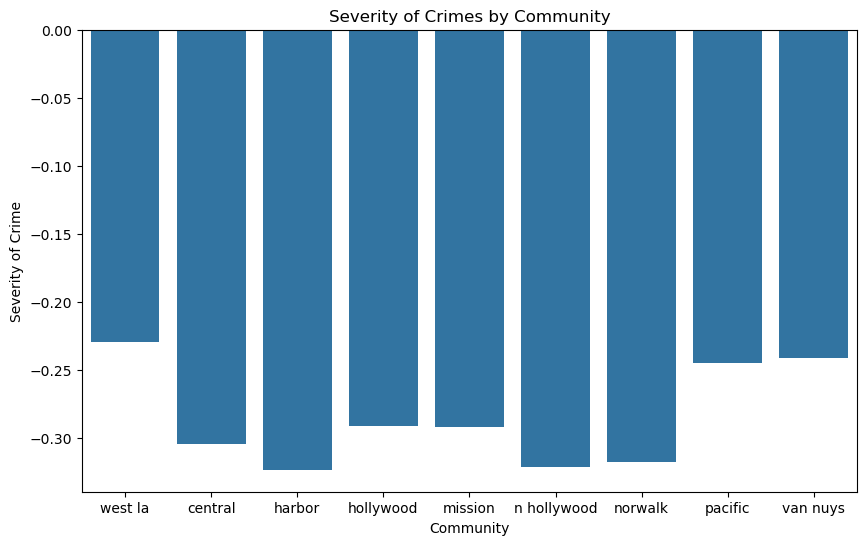

In [854]:
plt.figure(figsize = (10,6))
sns.barplot(data = heinous_df, x = 'Community', y = 'Severity of Crime')

plt.title('Severity of Crimes by Community')
plt.xlabel('Community')
plt.ylabel('Severity of Crime')

plt.show()

## Research Question #2: Does the Unemployment Rate have an affect on the amount of crimes being committed in the area?

In [857]:
# Now that we have sentience analysis, on the low, medium, and high rates of unemployment, let's visualize the relationship between
#number of crimes and unemployment rate

In [859]:
la_city_crime_summary = la_cleaned.groupby('Community').agg({
    'Charge Group Description': 'count',
    'Percent Unemployed': 'mean'
}).reset_index()

In [861]:
display(la_city_crime_summary)

,Community,Charge Group Description,Percent Unemployed
0,central,4387,6.322222
1,harbor,1858,5.233333
2,hollywood,7076,6.651522
3,mission,2782,3.950000
4,n hollywood,2433,6.035897
5,norwalk,2820,3.438095
6,pacific,2952,2.440000
7,van nuys,3449,7.477273
8,west la,1760,1.600000


In [863]:
# Visually

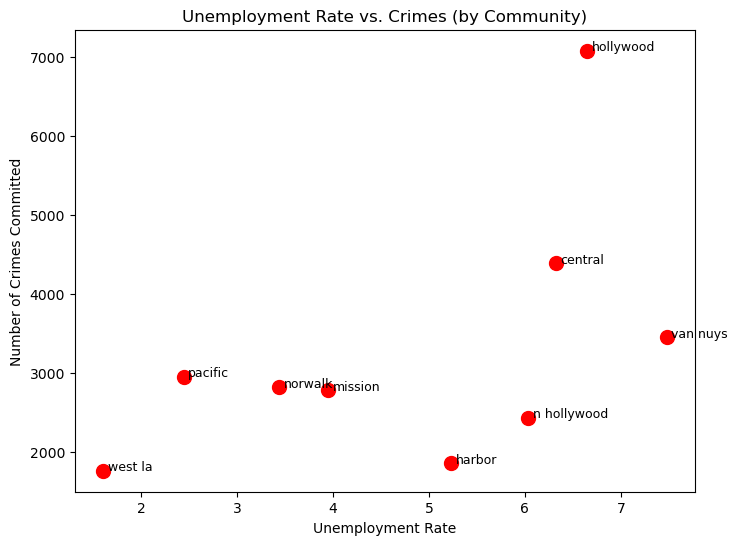

In [867]:
plt.figure(figsize = (8,6))
plt.scatter(la_city_crime_summary['Percent Unemployed'], la_city_crime_summary['Charge Group Description'], color = 'red', s = 100)

for i, row in la_city_crime_summary.iterrows():
    plt.text(row['Percent Unemployed'] + 0.05, row['Charge Group Description'], row['Community'], fontsize=9)

plt.title('Unemployment Rate vs. Crimes (by Community)')
plt.xlabel('Unemployment Rate')
plt.ylabel('Number of Crimes Committed')
plt.show()

In [869]:
# Correlation of Unemployment Rate and Number of Crimes

In [871]:
correlation = la_city_crime_summary['Percent Unemployed'].corr(la_city_crime_summary['Charge Group Description'])
print(f'The correlation of unemployment rate and number of crimes is {correlation}')

The correlation of unemployment rate and number of crimes is 0.5353748871027298


In [873]:
# Correlation without outliers (Hollywood)

In [875]:
outlierless_corr = la_city_crime_summary[la_city_crime_summary['Community'] != 'hollywood']
display(outlierless_corr)

,Community,Charge Group Description,Percent Unemployed
0,central,4387,6.322222
1,harbor,1858,5.233333
3,mission,2782,3.950000
4,n hollywood,2433,6.035897
5,norwalk,2820,3.438095
6,pacific,2952,2.440000
7,van nuys,3449,7.477273
8,west la,1760,1.600000


In [877]:
corr_less_outliers = outlierless_corr['Percent Unemployed'].corr(outlierless_corr['Charge Group Description'])
print(f'The correlation of unemployment rate and number of crimes without any outliers is: {corr_less_outliers}')

The correlation of unemployment rate and number of crimes without any outliers is: 0.515110479534024


## Hypothesis Testing --> Unemployment Rate vs. Number of Crimes

In [884]:
correlation, p_value = pearsonr(la_city_crime_summary['Percent Unemployed'], la_city_crime_summary['Charge Group Description'])

print('Null Hypotheis: The Unemployment Rate in a given neighborhood has no direct effect on the number of crimes comitted in the given neighborhood')

print(f'The correlation of Unemployment Rate to Number of Crimes being committed: {correlation}')
print(f'P_value for hypothesis test: {p_value}')

alpha = 0.05
if p_value < alpha:
    print('Reject the null hypothesis. There is significant correlation between unemployment affecting number of crimes committed.')
else:
    print('Fail to reject the null hypothesis. There is no significant correlation between unemployment affecting number of crimes committed.')
   

Null Hypotheis: The Unemployment Rate in a given neighborhood has no direct effect on the number of crimes comitted in the given neighborhood
The correlation of Unemployment Rate to Number of Crimes being committed: 0.5353748871027297
P_value for hypothesis test: 0.13743236339771409
Fail to reject the null hypothesis. There is no significant correlation between unemployment affecting number of crimes committed.


## What is the mean Unemployment Percentage among LA communities? (Univariate)

In [8]:
# This can be to address problems with LA as a whole, in digging into their unemployment issue

In [6]:
mean_unemployment_rate = la_city_crime_summary['Percent Unemployed'].mean()
print(f'The mean unemployment rate of the nine LA neighborhoods are: {mean_unemployment_rate}')

NameError: name 'la_city_crime_summary' is not defined